<a href="https://colab.research.google.com/github/kaikecc/Reinforcement-Learning/blob/main/src/notebook/RL_Google_Colab_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importação e Configuração do 3W Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from pathlib import Path
from multiprocessing.dummy import Pool as ThreadPool
from collections import defaultdict
from natsort import natsorted
from pathlib import Path
import logging

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
logging.basicConfig(filename='RL_log.txt',
                    filemode='w',
                    format='[%(levelname)s]\t%(asctime)s - %(message)s',
                    datefmt='%d/%m/%Y %I:%M:%S %p',
                    level=logging.DEBUG)

# Teste GPU TensorFlow

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

# Importação dos dados

In [3]:
#data_path = Path('/content/drive/MyDrive/Colab Notebooks/dataset')
data_path = Path('/home/dataset')

events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
columns = ['P-PDG',
           'P-TPT',
           'T-TPT',
           'P-MON-CKP',
           'T-JUS-CKP',
           'P-JUS-CKGL',
           'T-JUS-CKGL',
           'QGL',
           'class']
rare_threshold = 0.01

In [4]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            try:
                class_code = int(class_path.stem)
            except ValueError:
                # Se não for possível converter para int, pule este diretório
                continue

            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path


In [5]:
real_instances = list(class_and_file_generator(data_path, real=True, simulated=False, drawn=False))
simulated_instances = list(class_and_file_generator(data_path, real=False, simulated=True, drawn=False))
drawn_instances = list(class_and_file_generator(data_path, real=False, simulated=False, drawn=True))

print(f'Number of real instances: {len(real_instances)}')
print(f'Number of simulated instances: {len(simulated_instances)}')
print(f'Number of drawn instances: {len(drawn_instances)}')

Number of real instances: 1019
Number of simulated instances: 939
Number of drawn instances: 20


In [6]:
def load_instance(instances):
    class_code, instance_path = instances
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, index_col='timestamp', parse_dates=['timestamp'])
        assert (df.columns == columns).all(), "invalid columns in the file {}: {}".format(str(instance_path), str(df.columns.tolist()))
        df['label'] = class_code
        df['well'] = well
        df['id'] = instance_id
        df = df[['label', 'well', 'id'] + columns]
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))


df = load_instance(real_instances[0])
df.head()

,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,,,,
2014-01-26 08:01:46,4,WELL-00002,20140126080146,0.0,16166470.0,117.6411,6317682.0,173.0961,4217536.0,NaN,0.0,4
2014-01-26 08:01:47,4,WELL-00002,20140126080146,0.0,16166140.0,117.6411,6329183.0,173.0961,4217533.0,NaN,0.0,4
2014-01-26 08:01:48,4,WELL-00002,20140126080146,0.0,16165810.0,117.6410,6340685.0,173.0961,4217530.0,NaN,0.0,4
2014-01-26 08:01:49,4,WELL-00002,20140126080146,0.0,16165470.0,117.6409,6352186.0,173.0961,4217527.0,NaN,0.0,4
2014-01-26 08:01:50,4,WELL-00002,20140126080146,0.0,16165140.0,117.6408,6363688.0,173.0961,4217523.0,NaN,0.0,4


In [7]:


# Supondo que real_instances, simulated_instances, drawn_instances e events_names já estejam definidos
instances_class = [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'REAL'} for c, p in real_instances] + \
                  [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'SIMULATED'} for c, p in simulated_instances] + \
                  [{'TYPE OF EVENT': str(c) + ' - ' + events_names[c], 'SOURCE': 'DRAWN'} for c, p in drawn_instances]
df_class = pd.DataFrame(instances_class)

# Correção aqui: pivot(index, columns, values) com argumentos nomeados
df_class_count = df_class.groupby(['TYPE OF EVENT', 'SOURCE']).size().reset_index(name='count')
df_class_count = df_class_count.pivot(index='TYPE OF EVENT', columns='SOURCE', values='count').fillna(0).astype(int)

# Transposição não é necessária após a correção, mas ajustaremos a orientação conforme sua intenção original
#df_class_count = df_class_count.T

# Ordenação natural dos índices, se necessário
df_class_count = df_class_count.loc[natsorted(df_class_count.index)]

# Reordenar colunas se 'REAL', 'SIMULATED', 'DRAWN' estiverem presentes, adicionando a coluna 'TOTAL'
df_class_count['TOTAL'] = df_class_count.sum(axis=1)
df_class_count.loc['TOTAL'] = df_class_count.sum(axis=0)

# Exibindo o DataFrame final
df_class_count


SOURCE,DRAWN,REAL,SIMULATED,TOTAL
TYPE OF EVENT,,,,
0 - Normal,0,594,0,594
1 - Abrupt Increase of BSW,10,5,114,129
2 - Spurious Closure of DHSV,0,22,16,38
3 - Severe Slugging,0,32,74,106
4 - Flow Instability,0,344,0,344
5 - Rapid Productivity Loss,0,11,439,450
6 - Quick Restriction in PCK,0,6,215,221
7 - Scaling in PCK,10,5,0,15
8 - Hydrate in Production Line,0,0,81,81


# Criação de um único dataframe com todos os poços reais

In [8]:

# Carregar todos os DataFrames dos arquivos de instâncias reais
df_all_instances_real = [pd.DataFrame(load_instance(instance)) for instance in real_instances]

# Concatenar todos os DataFrames na lista para formar um único DataFrame
df = pd.concat(df_all_instances_real, ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14516197 entries, 0 to 14516196
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   label       int64  
 1   well        object 
 2   id          object 
 3   P-PDG       float64
 4   P-TPT       float64
 5   T-TPT       float64
 6   P-MON-CKP   float64
 7   T-JUS-CKP   float64
 8   P-JUS-CKGL  float64
 9   T-JUS-CKGL  float64
 10  QGL         float64
 11  class       float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.3+ GB


# Criação de um dataframe para o desenvolvimento de um Ambiente Python (TF)

Critério de seleção dos poços

1. Com mais de três tipos de eventos: 'WELL-00001', 'WELL-00002', 'WELL-00004', 'WELL-00006'
2. Dois poços para equilibrar a falta de eventos: 'WELL-00015', 'WELL-00016'

In [9]:
# Lista de poços para treinamento do modelo
wells_to_include = ['WELL-00001', 'WELL-00002', 'WELL-00004', 'WELL-00006', 'WELL-00015', 'WELL-00016']

# Selecionando colunas específicas
columns_to_select = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']

# Filtrando o DataFrame para incluir apenas os poços desejados e colunas específicas, e removendo linhas com NaNs
df_env = df[df['well'].isin(wells_to_include)][columns_to_select].dropna()

# Mostrando informações do DataFrame filtrado
df_env.info()

print(df_env.isna().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 9645620 entries, 0 to 14484284
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   P-PDG      float64
 1   P-TPT      float64
 2   T-TPT      float64
 3   P-MON-CKP  float64
 4   T-JUS-CKP  float64
 5   class      float64
dtypes: float64(6)
memory usage: 515.1 MB
P-PDG        0
P-TPT        0
T-TPT        0
P-MON-CKP    0
T-JUS-CKP    0
class        0
dtype: int64


# Pré-processamento dos dados do dataframe



In [10]:
# Colunas para normalizar, exceto 'class'
columns_to_normalize = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']

# Aplicando Z-score Standardization
df_env[columns_to_normalize] = (df_env[columns_to_normalize] - df_env[columns_to_normalize].mean()) / df_env[columns_to_normalize].std()

# Converte a coluna 'class' para valor int
df_env['class'] = df_env['class'].astype(int)

# Verifique as primeiras linhas para confirmar a normalização
df_env.head()


,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
0,0.195413,-0.063940,0.178590,0.367639,3.059375,4
1,0.195413,-0.063941,0.178590,0.370626,3.059375,4
2,0.195413,-0.063943,0.178576,0.373613,3.059375,4
3,0.195413,-0.063944,0.178562,0.376600,3.059375,4
4,0.195413,-0.063946,0.178547,0.379587,3.059375,4


Normal: 7830083 - 81.18%
Transiente de anomalia: 365683 - 3.79%
Estável de anomalia: 1449854 - 15.03%
Total: 9645620


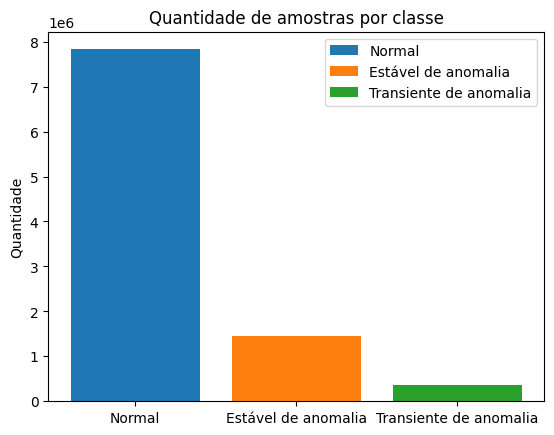

In [11]:

def plot_estados(df_env):
    # Contagem de valores para cada classe
    class_counts = df_env['class'].value_counts().sort_index()
    # soma os valores de 1 a 9 e 101 a 109
    rare_class_counts_A = class_counts[(class_counts.index > 0) & (class_counts.index < 10)].sum()
    rare_class_counts_B = class_counts[(class_counts.index > 10)].sum()
    rare_class_counts_C = class_counts[(class_counts.index == 0)].sum()

    # Total de amostras
    total = rare_class_counts_A + rare_class_counts_B + rare_class_counts_C

    print(f'Normal: {rare_class_counts_C} - {round(rare_class_counts_C/total*100, 2)}%')
    print(f'Transiente de anomalia: {rare_class_counts_B} - {round(rare_class_counts_B/total*100, 2)}%')
    print(f'Estável de anomalia: {rare_class_counts_A} - {round(rare_class_counts_A/total*100, 2)}%')
    print(f'Total: {rare_class_counts_A + rare_class_counts_B + rare_class_counts_C}')

    fig, ax = plt.subplots()
    ax.bar('Normal', rare_class_counts_C, label='Normal')
    ax.bar('Estável de anomalia', rare_class_counts_A, label='Estável de anomalia')
    ax.bar('Transiente de anomalia', rare_class_counts_B, label='Transiente de anomalia')

    ax.set_ylabel('Quantidade')
    ax.set_title('Quantidade de amostras por classe')
    ax.legend()
    plt.show()

plot_estados(df_env)

# Classe 3W - Ambiente TF

In [ ]:
#!pip install tf-agents
#!pip install dm-reverb[tensorflow]
#!pip install dm-reverb


In [12]:

from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts

class env3W(py_environment.PyEnvironment):
    '''
    Essa classe é um Modelo-Livre do Ambiente em python para o problema de detecção de falhas em poços de petróleo.
    O dataframe é fornecido como entrada para o ambiente com mais de 10 milhões de registros.

     1. O ambiente é um repositório di github https://github.com/petrobras/3W
     2. O ambiente é composto por dados de seis poços de petróleo, com cinco variáveis (observações) de entrada ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'] e um rótulo indentificador de falha [class]
     3. O ambiente é um ambiente de simulação, onde o agente pode escolher entre duas ações: 0 - Não Detectado ou 1 - Detectado para cada observação
     4. A recompensa é calculada com base na ação escolhida e no rótulo de falha [class]:

        Estados:
        - rótulo de falha: 0 - Estado Normal
        - rótulo de falha: 1 a 8 - Estável de Anomalia (Falha)
        - rótulo de falha: 101 a 108 - Transiente de Anomalia (Falha)

        Ações/Recompensas:
        - Se o rótulo de falha for 0, a recompensa é 1 se a ação for 0, caso contrário, a recompensa é -100
        - Se o rótulo de falha estiver entre 1 e 8, a recompensa é -100 se a ação for 0, caso contrário, a recompensa é 100
        - Se o rótulo de falha estiver entre 101 e 108, a recompensa é -10 se a ação for 0, caso contrário, a recompensa é 10
    
    '''
    def __init__(self, dataframe):
        super(env3W, self).__init__()
        self._dataframe = dataframe
        self._index = 0
        # Ação: 0 - Não Deectado ou 1 - Detectado
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=1, name='action') 
        self.columns_needed = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']               
        num_features = len(self.columns_needed)
        self._observation_spec = array_spec.BoundedArraySpec(shape=(num_features,), dtype=np.float32, name='observation')
        row = self._dataframe.iloc[self._index][self.columns_needed]
        self._state = row.values
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
   
    def _update_state(self):
        # Avaliar o index se é +1 ou não    
        row = self._dataframe.iloc[self._index][self.columns_needed]
        self._state = row.values

   
    def _reset(self):
        self._index = 0
        self._update_state()
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))
    
    
    def _step(self, action):

        # Verifica se a ação é válida
        if not 0 <= action <= 1:
            return ts.termination(np.array(self._state, dtype=np.float32), reward=0)             
        
        self._update_state()
        reward = self._calculate_reward(action)

        if self._episode_ended or self._index >= len(self._dataframe) - 1:
            # Quando chegar na última linha, marque o episódio como terminado e pare.
            self._episode_ended = True            
            return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
        else:
            self._index += 1
            return ts.transition(np.array(self._state, dtype=np.float32), reward=reward, discount=1.0)
               
          
    def _calculate_reward(self, action):
        class_value = self._dataframe.iloc[self._index]['class']
        if class_value == 0:
            return 0.01 if action == 0 else -1
        elif class_value in range(1, 9):
            return -1 if action == 0 else 1
        elif class_value in range(101, 109):
            return -0.1 if action == 0 else 0.1
        else:
            # Define uma recompensa padrão para qualquer outro valor de class não especificado
            return 0
       
      


2024-02-26 14:38:20.508755: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-26 14:38:20.666598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup

In [13]:
#import sys
#import os
#sys.path.append(os.path.join('..'))
#from classes._env3W import env3W  # Ajuste para o caminho correto da sua classe de ambiente

import reverb
import tensorflow as tf


from tf_agents.environments import utils
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
from tf_agents.drivers import py_driver
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import time_step as ts
from tf_agents.policies import random_tf_policy

# Hiperparâmentros

In [14]:
initial_collect_steps = 1000  # Número de passos de coleta inicial
collect_steps_per_iteration = 1  # Passos de coleta por iteração de treinamento
replay_buffer_max_length = 100000  # Tamanho máximo do replay buffer

log_interval = 1000  # Log do progresso a cada 1000 iterações de treinamento
eval_interval = 5000  # Avaliação do desempenho do agente a cada 5000 iterações
batch_size = 64  # Exemplo de tamanho de batch para treinamento
num_iterations = 10000  # Exemplo de número de iterações de treinamento
learning_rate= 1e-3 # Taxa de aprendizado

num_eval_episodes = 20  # @param {type:"integer"}
num_parallel_envs = 5

# Ambiente

No Aprendizado por Reforço (RL), um ambiente representa a tarefa ou problema a ser resolvido. Ambientes padrão podem ser criados em TF-Agents usando conjuntos tf_agents.environments.

1. O ambiente é um repositório di github https://github.com/petrobras/3W
2. O ambiente é composto por dados de seis poços de petróleo, com cinco variáveis (observações) de entrada ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'] e um rótulo indentificador de falha [class]
3. O ambiente é um ambiente de simulação, onde o agente pode escolher entre duas ações: 0 - Não Detectado ou 1 - Detectado para cada observação
4. A recompensa é calculada com base na ação escolhida e no rótulo de falha [class]:

Estados:
- rótulo de falha: 0 - Estado Normal
- rótulo de falha: 1 a 8 - Estável de Anomalia (Falha)
- rótulo de falha: 101 a 108 - Transiente de Anomalia (Falha)

Ações/Recompensas:
- Se o rótulo de falha for 0, a recompensa é 1 se a ação for 0, caso contrário, a recompensa é -100
- Se o rótulo de falha estiver entre 1 e 8, a recompensa é -100 se a ação for 0, caso contrário, a recompensa é 100
- Se o rótulo de falha estiver entre 101 e 108, a recompensa é -10 se a ação for 0, caso contrário, a recompensa é 10

In [15]:
from tf_agents.system import multiprocessing as tf_multiprocessing

# Chame isto apenas uma vez no início do notebook
tf_multiprocessing.enable_interactive_mode()

# desabilitar o enable_interactive_mode

#tf_multiprocessing.disable_interactive_mode()

In [16]:
from tf_agents.environments import tf_py_environment, ParallelPyEnvironment

# Amostra aleatória de 1% dos dados
df_test = df_env.sample(frac=0.01, random_state=42).reset_index(drop=True)


# Criação de um ambiente de teste
env = env3W(df_test)

# Criação de num_parallel_envs ambientes de teste
parallel_env = ParallelPyEnvironment([lambda: env3W(df_test) for _ in range(num_parallel_envs)])
tf_env = tf_py_environment.TFPyEnvironment(parallel_env)


Normal: 78173 - 81.05%
Transiente de anomalia: 3677 - 3.81%
Estável de anomalia: 14606 - 15.14%
Total: 96456


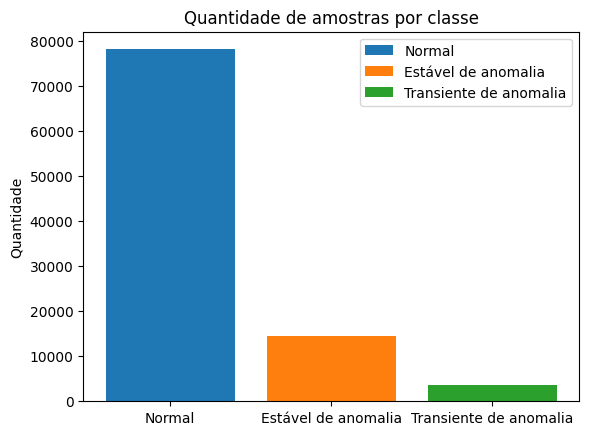

In [17]:
plot_estados(df_test)

Para validar o ambiente, é usado uma política aleatória para gerar ações e faremos a iteração em mais de 5 episódios para garantir que as coisas estejam funcionando como pretendido. Um erro é gerado se recebermos um time_step que não segue as especificações do ambiente.

In [ ]:
# depois de 1h30 - cancelando verificação, no mo meu pc 54min com 10%, 36Mmin paralelo
utils.validate_py_environment(env, episodes=5)

In [ ]:
utils.validate_py_environment(parallel_env, episodes=5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

reward_list = []

# Cria um step_list de 0 a 99 ao passo de 1
step_list = np.arange(0, len(df_test), 1)

# Para garantir que o ambiente esteja no estado inicial antes de começar a simulação
time_step = env.reset()
cumulative_reward = 0
index = 0   
for step in step_list:
    # Supondo que 'detect' seja uma ação válida para o ambiente 'env'
    if df_test['class'][index] == 0:
        detect = np.array(0, dtype=np.int32)
    elif df_test['class'][index] in range(1, 9):
        detect = np.array(1, dtype=np.int32)
    elif df_test['class'][index] in range(101, 109):
        detect = np.array(1, dtype=np.int32)

    index += 1
    #detect = np.array(np.random.choice([0, 1]), dtype=np.int32)
    time_step = env.step(detect)
    cumulative_reward += time_step.reward
    reward_list.append(cumulative_reward)

# Plotar o gráfico step_list x reward_list
plt.plot(step_list, reward_list)
plt.xlabel('Passos')
plt.ylabel('Recompensa Cumulativa')
plt.title('Política Ótima : Passos vs Recompensa')
plt.show()


In [ ]:
env.reset()
parallel_env.reset()

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print(parallel_env.time_step_spec().observation)

In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)
print(parallel_env.time_step_spec().reward)

In [ ]:
print('Action Spec:')
print(env.action_spec())
print(parallel_env.action_spec())

No ambiente env3W:

* Observação é um array de cinco floats:

    * Três sensores de pressão: 'P-PDG', 'P-TPT', 'P-MON-CKP'
    * Dois sensores de temperatura: 'T-TPT', T-JUS-CKP'

* A recompensa é um escalar inteiro.

* A ação é um escalar inteiro com duas possibilidades:

    * 0 — "Não Detectado"
    * 1 — "Detectado"

In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Normalmente dois ambientes são instanciados: um para treinamento e outro para avaliação.

In [18]:

train_py_env = parallel_env
eval_py_env = parallel_env

In [19]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)  # Avaliação pode ser em um env similar ou diferente


# Agente

O algoritmo utilizado para resolver um problema de RL é representado por um Agente. TF-Agents fornece implementações padrão de uma variedade de Agentes, incluindo:

* DQN (Usado para teste)
* REINFORCE
* DDPG
* TD3
* PPO
* SAC

O agente DQN pode ser utilizado em qualquer ambiente que possua um espaço de ação discreto.

No coração de um Agente DQN está uma QNetwork, um modelo de rede neural que pode aprender a prever QValues (retornos esperados) para todas as ações, dada uma observação do ambiente.

Usaremos tf_agents.networks. para criar uma QNetwork. A rede será composta por uma sequência de camadas tf.keras.layers.Dense, onde a camada final terá 1 saída para cada ação possível.

In [20]:
fc_layer_params = (100, 50)  # Exemplo de tamanho das camadas totalmente conectadas
action_tensor_spec = tensor_spec.from_spec(parallel_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Defina uma função auxiliar para criar camadas densas configuradas com o direito
# ativação e inicializador do kernel.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))


# QNetwork consiste em uma sequência de camadas densas seguidas por uma camada densa
# com unidades `num_actions` para gerar um q_value por ação disponível como sua saída.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

Agora use tf_agents.agents.dqn.dqn_agent para instanciar um DqnAgent. Além de time_step_spec, action_spec e QNetwork, o construtor do agente também requer um otimizador (neste caso, AdamOptimizer), uma função de perda e um contador de passos inteiro.

In [21]:

q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [22]:


optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# Política

Uma política define a forma como um agente atua em um ambiente. Normalmente, o objetivo da aprendizagem por reforço é treinar o modelo subjacente até que a política produza o resultado desejado.

* O resultado desejado é a identificar uma falha com base nas observações
* A política retorna uma ação (Não Detectado ou Detectado) para cada observação time_step.

Os agentes contêm duas políticas:

* agent.policy — A política principal usada para avaliação e implantação.
* agent.collect_policy — Uma segunda política usada para coleta de dados.

In [23]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

As políticas podem ser criadas independentemente dos agentes. Por exemplo, use tf_agents.policies.random_tf_policy para criar uma política que selecionará aleatoriamente uma ação para cada time_step.

In [24]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

Para obter uma ação de uma política, chame o método policy.action(time_step). O time_step contém a observação do ambiente. Este método retorna um PolicyStep, que é uma tupla nomeada com três componentes:

* ação - a ação a ser executada (neste caso, 0 ou 1)
* estado – usado para políticas com estado (isto é, baseadas em ANN)
* info — dados auxiliares, como log de probabilidades de ações

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(env3W(df_test))

In [ ]:
time_step = example_environment.reset()

In [ ]:


random_policy.action(time_step)

In [25]:
time_step = tf_env.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 0, 0, 1, 0], dtype=int32)>, state=(), info=())

# Métricas e Avaliação

A métrica mais comum usada para avaliar uma política é o retorno médio. O retorno é a soma das recompensas obtidas durante a execução de uma política em um ambiente durante um episódio. Vários episódios são executados, criando um retorno médio.

A função a seguir calcula o retorno médio de uma política, dada a política, o ambiente e um número de episódios

In [ ]:
import numpy as np

def compute_avg_return(environment, policy, num_episodes):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics


eval_env_one = tf_py_environment.TFPyEnvironment(env3W(df_test))
#compute_avg_return(eval_env_one, random_policy, num_episodes = 10)

In [26]:
import tensorflow as tf
import numpy as np

def parallel_compute_avg_return_test(environment, policy, num_parallel_envs, num_eval_episodes):
    total_return = 0.0
    num_episodes_per_env = np.ceil(num_eval_episodes / num_parallel_envs).astype(int)
    
    time_step = environment.reset()
    episode_return = tf.zeros(num_parallel_envs)
    episode_counts = np.zeros(num_parallel_envs, dtype=int)
    total_episodes = 0

    logging.info(f'Número de Episódios por Ambiente: {num_episodes_per_env}')
    while total_episodes < num_eval_episodes:
        policy_step = policy.action(time_step)
        time_step = environment.step(policy_step.action)
        episode_return += time_step.reward

        #logging.info(f'episode_return: {episode_return}')
        for i in range(num_parallel_envs):
            if time_step.is_last()[i]:
                total_return += episode_return[i]
                # Atualiza episode_return usando operações do TensorFlow
                episode_return = tf.tensor_scatter_nd_update(
                    episode_return, 
                    indices=[[i]], 
                    updates=[0.0]
                )
                episode_counts[i] += 1
                total_episodes += 1
                if total_episodes >= num_eval_episodes:
                    break

    avg_return = total_return / num_eval_episodes
    logging.info(f'Recompensa Média: {avg_return}')
    return avg_return



A execução desse cálculo em random_policy mostra um desempenho de linha de base no ambiente.

In [ ]:
# 99min value -387301.46008750144
import numpy as np
from tf_agents.environments import tf_py_environment, ParallelPyEnvironment
from tf_agents.policies import random_tf_policy
    
    
average_return = parallel_compute_avg_return_test(tf_env, random_policy, num_parallel_envs = 5, num_eval_episodes=10)
print(f'Average return: {average_return}')

# Replay Buffer

Para acompanhar os dados coletados do ambiente, usaremos o Reverb, um sistema de replay eficiente, extensível e fácil de usar da Deepmind. Ele armazena dados de experiência quando coletamos trajetórias e são consumidos durante o treinamento.

Este buffer de reprodução é construído usando especificações que descrevem os tensores que devem ser armazenados, que podem ser obtidos do agente usando agent.collect_data_spec.

In [27]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)



[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmphtwobs5q.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmphtwobs5q
[reverb/cc/platform/default/server.cc:71] Started replay server on port 40943


Para a maioria dos agentes, collect_data_spec é uma tupla nomeada chamada Trajetória, contendo especificações para observações, ações, recompensas e outros itens.

In [28]:
agent.collect_data_spec


Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(5,), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [29]:
agent.collect_data_spec._fields


('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

# Coleta de dados

Agora execute a política aleatória no ambiente por algumas etapas, registrando os dados no buffer de reprodução.

Aqui estamos usando 'PyDriver' para executar o ciclo de coleta de experiência. Você pode aprender mais sobre o driver TF Agents em nosso

In [ ]:
# Um ambiente de treinamento

py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(env.reset())

In [ ]:
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy, py_tf_eager_policy
from tf_agents.metrics import py_metrics, tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory as traj
from tf_agents.environments import ParallelPyEnvironment

# Suposição: 'env3W' e 'df_test' estão definidos corretamente
# Suposição: 'num_parallel_envs' está definido corretamente

# Criação de num_parallel_envs ambientes de teste em paralelo
parallel_env = ParallelPyEnvironment([lambda: env3W(df_test) for _ in range(num_parallel_envs)])
tf_env = tf_py_environment.TFPyEnvironment(parallel_env)

# Suposição: 'agent' já está definido e inicializado corretamente

# Inicializa o Replay Buffer com batch_size correto
replay_buffer = TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=num_parallel_envs,  # Importante para ambientes paralelos
    max_length=replay_buffer_max_length)

# Inicializa o Driver para coleta de experiências
collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps)

# Executa o driver para coletar experiências
time_step = tf_env.reset()  # Use tf_env para resetar, não parallel_env diretamente
final_time_step, _ = collect_driver.run(time_step)


O buffer de repetição agora é uma coleção de trajetórias

In [ ]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()


O agente precisa de acesso ao buffer de reprodução. Isso é fornecido pela criação de um pipeline tf.data.Dataset iterável que alimentará os dados para o agente.

Cada linha do buffer de reprodução armazena apenas uma única etapa de observação. Mas como o Agente DQN precisa da observação atual e da próxima para calcular a perda, o pipeline do conjunto de dados irá amostrar duas linhas adjacentes para cada item no lote (num_steps=2).

Este conjunto de dados também é otimizado executando chamadas paralelas e pré-busca de dados.

In [32]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 5), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [33]:

iterator = iter(dataset)
print(iterator)

In [ ]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data
# to the collection of individual trajectories shown earlier.

# iterator.next()

# Treinando o agente

Duas coisas devem acontecer durante o ciclo de treinamento:

* coletar dados do ambiente
* usar esses dados para treinar a(s) rede(s) neural(is) do agente

Este exemplo também avalia periodicamente a política e imprime a pontuação atual.

O seguinte levará cerca de 5 minutos para ser executado.

# Testando

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tf_agents.environments import tf_py_environment, ParallelPyEnvironment
from tf_agents.policies import py_tf_eager_policy
from tf_agents.drivers import py_driver
from tf_agents.utils import common
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy, py_tf_eager_policy
from tf_agents.metrics import py_metrics, tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.trajectories import trajectory as traj
from tf_agents.environments import ParallelPyEnvironment
# Suponha que todas as importações e definições necessárias estejam completas

logging.info('Iniciando o ambiente de treinamento')
def create_env():
    return env3W(df_test)  # Suponha que env3W e df_test estejam definidos corretamente


num_parallel_envs = 5
parallel_env = ParallelPyEnvironment([lambda: create_env() for _ in range(num_parallel_envs)])
tf_env = tf_py_environment.TFPyEnvironment(parallel_env)

logging.info(f'Criando {num_parallel_envs} ambientes env3W em paralelo')

# (Optional) Otimizações com TF function
agent.train = common.function(agent.train)
logging.info('Otimizando agent.train com TF function')

# Reseta o contador de passos de treinamento
agent.train_step_counter.assign(0)
logging.info('Resetando o contador de passos de treinamento')


logging.info('Iniciando a avaliação da política do agente antes do treinamento')
# Avalia a política do agente antes do treinamento
average_return = parallel_compute_avg_return_test(tf_env, agent.policy, num_parallel_envs, num_eval_episodes)
returns = [average_return]
logging.info(f'Recompensa Média: {average_return}')


logging.info('Iniciando o treinamento do agente')
# Reseta o ambiente
time_step = tf_env.reset()

# Inicializa o Replay Buffer com batch_size correto
replay_buffer = TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=num_parallel_envs,  # Importante para ambientes paralelos
    max_length=replay_buffer_max_length)

# Inicializa o Driver para coleta de experiências
collect_driver = dynamic_step_driver.DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps)

logging.info('Iniciando a coleta de experiências')
for i in range(num_iterations):

    logging.debug(f'Iteração {i}')
    print(f'Iteração {i}')
    # Coleta alguns passos e salva no replay buffer
    time_step, _ = collect_driver.run(time_step)

    # Amostra um batch de dados do buffer e atualiza a rede do agente
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    # Loga o progresso a cada log_interval passos
    if step % log_interval == 0:
        logging.debug(f'Logando o progresso a cada {log_interval} passos')
        logging.info(f'step = {step}: loss = {train_loss}')

    # Avalia a política do agente a cada eval_interval passos
    if step % eval_interval == 0:
        logging.debug(f'Avaliando a política do agente a cada {eval_interval} passos')
        average_return = parallel_compute_avg_return_test(tf_env, agent.policy, num_parallel_envs, num_eval_episodes)        
        logging.info(f'step = {step}: Average Return = {average_return}')
        returns.append(average_return)

    print(f'step = {step}: loss = {train_loss}')

iterations = range(0, num_iterations + 1, eval_interval)
logging.info(f'Iterações: {iterations}')
logging.info(f'Recompensas: {returns}')
logging.info('Treinamento concluído')

# Plota os retornos
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.show()


Iteração 0
step = 1: loss = 0.20564475655555725
Iteração 1
step = 2: loss = 0.3485100269317627
Iteração 2
step = 3: loss = 0.20105120539665222
Iteração 3
step = 4: loss = 0.19038879871368408
Iteração 4
step = 5: loss = 0.24767561256885529
Iteração 5
step = 6: loss = 0.3705195486545563
Iteração 6
step = 7: loss = 0.3112737536430359
Iteração 7
step = 8: loss = 0.43279433250427246
Iteração 8
step = 9: loss = 0.31545090675354004
Iteração 9
step = 10: loss = 0.2994927167892456
Iteração 10
step = 11: loss = 0.39934423565864563
Iteração 11
step = 12: loss = 0.4041481614112854
Iteração 12
step = 13: loss = 0.2673070430755615
Iteração 13
step = 14: loss = 0.3761555552482605
Iteração 14
step = 15: loss = 0.3042941987514496
Iteração 15
step = 16: loss = 0.2263992726802826
Iteração 16
step = 17: loss = 0.332145631313324
Iteração 17
step = 18: loss = 0.41403400897979736
Iteração 18
step = 19: loss = 0.2567451000213623
Iteração 19
step = 20: loss = 0.3216613531112671
Iteração 20
step = 21: loss = 0.

# Funciona

In [ ]:
# 883 min - canceling
'''try:
  %%time
except:
  pass'''

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

print(f'Recompensa Média: {avg_return}')

# Reset the environment.
time_step = env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

# Visualização

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)